In [10]:
from langgraph.graph import StateGraph ,START,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict,Annotated
from pydantic import BaseModel,Field
import operator

In [2]:
load_dotenv()

True

In [3]:
model=ChatOpenAI(model='gpt-4o-mini')

In [4]:
class EvaluationSchema(BaseModel):
    feedback:str=Field(description="detailed feedback for the essay")
    score:int=Field(description="score out of 10",ge=0,le=10)

In [5]:
structured_model=model.with_structured_output(EvaluationSchema)

In [6]:
essay=""" Role of India in Artificial Intelligence

Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century, reshaping economies, industries, and societies worldwide. India, as one of the fastest-growing digital economies, has recognized the potential of AI in driving innovation, solving societal challenges, and strengthening global competitiveness. The country’s role in the global AI ecosystem is becoming increasingly significant due to its large talent pool, robust IT industry, and government initiatives.

1. Government Initiatives

The Government of India has placed AI at the core of its digital and economic strategy. NITI Aayog released the National Strategy for Artificial Intelligence in 2018, identifying five key focus areas: healthcare, agriculture, education, smart mobility, and smart cities. Programs such as Digital India, Startup India, and IndiaAI Mission are fostering innovation, infrastructure, and entrepreneurship in the AI ecosystem. Additionally, AI is being integrated into governance through projects like AI-powered citizen services, crop monitoring, traffic management, and digital health records.

2. AI Research and Development

India has a strong presence in AI research, driven by premier institutes such as the Indian Institute of Technology (IITs), Indian Institute of Science (IISc), and research labs of global tech companies. Collaborative efforts between academia, industry, and government are advancing R&D in natural language processing, computer vision, machine learning, and robotics. India’s contribution is also evident in open-source projects, AI publications, and patents.

3. Industry and Startups

The Indian IT sector, led by companies such as TCS, Infosys, and Wipro, is integrating AI into global business solutions. Moreover, a vibrant startup ecosystem has emerged, with AI-driven companies working on healthcare diagnostics, fintech solutions, agriculture technologies, and e-commerce personalization. India ranks among the top countries in terms of AI startup funding and innovation, making it a key player in the global AI market.

4. Talent Pool

India’s demographic advantage plays a crucial role in its AI journey. With one of the world’s largest pools of engineers, data scientists, and software developers, India supplies skilled professionals not only domestically but also to international companies. Many Indian experts occupy leadership positions in global AI research labs and technology firms, highlighting the nation’s human capital strength.

5. Societal Impact

AI in India is not just about business—it is about addressing local challenges. For example:

Agriculture: AI is helping farmers with predictive analytics, crop monitoring, and precision farming.

Healthcare: AI is enabling affordable diagnostics, telemedicine, and drug discovery.

Education: Personalized learning platforms and AI-driven content are bridging the gap in access to quality education.

Governance: Smart city projects are improving traffic flow, waste management, and energy efficiency.

6. Challenges Ahead

Despite its progress, India faces challenges in AI adoption, including lack of high-quality datasets, limited investment in advanced R&D, ethical concerns, and digital divide issues. Bridging the urban-rural digital gap and ensuring responsible AI governance will be essential for inclusive growth.

7. Global Role

India’s approach to AI is unique because it emphasizes “AI for All”—a philosophy of using technology not just for economic gain but also for social good. With collaborations in G20, BRICS, and partnerships with global tech companies, India is shaping the ethical, inclusive, and sustainable use of AI on a global scale.

Conclusion

India’s role in Artificial Intelligence is both promising and impactful. With its strong digital infrastructure, young workforce, and commitment to “AI for social good,” India has the potential to become a global AI hub. By addressing challenges and fostering innovation, the country can leverage AI not only to boost economic growth but also to transform lives, ensuring inclusive and sustainable development for the future."""

In [7]:
prompt=f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"

In [8]:
structured_model.invoke(prompt)

EvaluationSchema(feedback="The essay on the role of India in Artificial Intelligence (AI) is well-structured and informative, covering a comprehensive range of topics relevant to India's involvement in the AI landscape. The language quality is quite good, with articulate expressions and a coherent flow of ideas. There are clear sections that address key aspects such as government initiatives, R&D, industry contributions, talent pool, societal impact, challenges, and India’s global positioning in AI. \n\nStrengths:\n1. **Clarity and Organization**: The essay is logically organized, with distinct headings for each section that help guide the reader through the complex topic.\n2. **Informative Content**: The content provides valuable insights into the various dimensions of AI in India, showcasing both the positive aspects and challenges.\n3. **Language Quality**: The language used is professional, with an appropriate level of detail and technical terminology that is well-explained.\n\nAre

In [12]:
class UPSCState(TypedDict):
    essay:str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_score:Annotated[list[int],operator.add]
    avg_score:float

In [15]:
def evaluate_language(state:UPSCState):
    prompt=f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output=structured_model.invoke(prompt)
    
    return {'language_feedback':output.feedback,'individual_score':[output.score]}
    

In [16]:
def evaluate_analysis(state:UPSCState):
    prompt=f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output=structured_model.invoke(prompt)
    
    return {'analysis_feedback':output.feedback,'individual_score':[output.score]}
    

In [17]:
def evaluate_thought(state:UPSCState):
    prompt=f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output=structured_model.invoke(prompt)
    
    return {'clarity_feedback':output.feedback,'individual_score':[output.score]}
    

In [19]:
def final_evaluation(state:UPSCState):
    prompt=f"Based on the following feedback create a summarized feedback \n language feedback - {state['language_feedback']} \n depth of analysis - {state['analysis_feedback']} \n clarity of thought -{state['clarity_feedback']}"
    overall_feedback=model.invoke(prompt).content
    
    avg_score=sum(state['individual_score'])/len(state['individual_score'])
    return {'overall_feedback':overall_feedback,'avg_score':avg_score}

In [22]:
graph=StateGraph(UPSCState)
    
graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node("evaluate_thought",evaluate_thought)
graph.add_node("final_evaluation",final_evaluation)
    

In [23]:
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thought')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')

graph.add_edge('final_evaluation',END)

In [24]:
workflow=graph.compile()

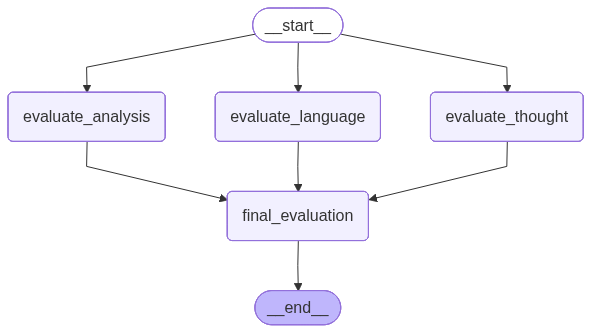

In [25]:
workflow

In [26]:
initial_state={
    'essay':essay
}
workflow.invoke(initial_state)

{'essay': ' Role of India in Artificial Intelligence\n\nArtificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century, reshaping economies, industries, and societies worldwide. India, as one of the fastest-growing digital economies, has recognized the potential of AI in driving innovation, solving societal challenges, and strengthening global competitiveness. The country’s role in the global AI ecosystem is becoming increasingly significant due to its large talent pool, robust IT industry, and government initiatives.\n\n1. Government Initiatives\n\nThe Government of India has placed AI at the core of its digital and economic strategy. NITI Aayog released the National Strategy for Artificial Intelligence in 2018, identifying five key focus areas: healthcare, agriculture, education, smart mobility, and smart cities. Programs such as Digital India, Startup India, and IndiaAI Mission are fostering innovation, infrastructure, and entrepreneurshi

In [27]:
essay2=""" India play very big role in Artificial Intelligence. Today AI is growing very fast in world and India also not behind. Government of India make many plan like Digital India and AI mission to bring AI in health, farming, education and transport.

In India many IT company like TCS, Infosys, Wipro use AI for solving business problem. Also many new startup coming which work on AI in farming, medicine, shopping and money app. India also have big young population who learn computer and coding, so India have big talent pool in AI. Many Indian people also work in big company in America and other country, so India brain power is respected in world.

AI is helping India in many way. In farming, it tell farmer when to grow crop. In health, AI machine help doctor to find disease. In school, AI can give student personal learning. In city, AI is use in traffic and waste management."""

In [28]:
initial_state={
    'essay':essay2
}
workflow.invoke(initial_state)

{'essay': ' India play very big role in Artificial Intelligence. Today AI is growing very fast in world and India also not behind. Government of India make many plan like Digital India and AI mission to bring AI in health, farming, education and transport.\n\nIn India many IT company like TCS, Infosys, Wipro use AI for solving business problem. Also many new startup coming which work on AI in farming, medicine, shopping and money app. India also have big young population who learn computer and coding, so India have big talent pool in AI. Many Indian people also work in big company in America and other country, so India brain power is respected in world.\n\nAI is helping India in many way. In farming, it tell farmer when to grow crop. In health, AI machine help doctor to find disease. In school, AI can give student personal learning. In city, AI is use in traffic and waste management.',
 'language_feedback': "The essay presents relevant points about India's role in Artificial Intelligen